# AOSLO Crowding & Microsaccades:

  This script is used to analyse and plot crowding and microsaccade data and to be able to understand the relationship   between the two.

In [1]:
%pylab inline
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Progress bar function
def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [7]:
# First we import the different dataframes created from the analysis protocols and also the behavioral data
os.chdir("D:\KSP\Study\Houston\Projects\TSLOExperiments\CrowdingMicrosaccade\AOData\AnalysisOutput")
saccData=pd.read_csv('microSaccData.csv')
behavData=pd.read_csv("df_behavioral_per_trial.csv")
filteredeyepos=pd.read_pickle("filteredEyePos.pkl")
driftData=pd.read_csv("driftDataFiltered.csv")
bceaDF=pd.read_csv("bceaDF.csv")
stdDF=pd.read_pickle("stdDF.pkl")
# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that
# are below 0
saccData['DirectionPolar']=0
for i in range(len(saccData)):
    if saccData['Direction'].iloc[i]<0:
        saccData['DirectionPolar'].iloc[i]=saccData['Direction'].iloc[i]+360
    else:
        saccData['DirectionPolar'].iloc[i]=saccData['Direction'].iloc[i]
        
saccDataUnfiltered['DirectionPolar']=0
for i in range(len(saccDataUnfiltered)):
    if saccDataUnfiltered['Direction'].iloc[i]<0:
        saccDataUnfiltered['DirectionPolar'].iloc[i]=saccDataUnfiltered['Direction'].iloc[i]+360
    else:
        saccDataUnfiltered['DirectionPolar'].iloc[i]=saccDataUnfiltered['Direction'].iloc[i]

# We create a column that contains an unique subject code which can later be used to merge the behavioral data 
# with other dataframes
def row_to_code_behav(x):
    return "%s_%s_%03d"%(x.vidcode,x.subj,x.ntrial+1)

behavData["code"]=(behavData.apply(row_to_code_behav,1)).astype(str)

# The behavioral data and saccade data are merged together
saccDataMerged=pd.merge(saccData,behavData,left_on='code',right_on='code')
saccDataUnfiltered=pd.merge(saccDataUnfiltered,behavData,left_on='code',right_on='code')

# We clean up the code column in the filtered eye positions dataframe and the drift data
filteredeyepos['code']=filteredeyepos['code'].str.replace('/mnt/hd/ao/vids/','',regex=True)
driftData['code']=driftData['code'].str.replace('/mnt/hd/ao/vids/','',regex=True)


C:\Users\krish\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


NameError: name 'saccDataUnfiltered' is not defined

In [ ]:
# #calculating BCEA (68% confidence ellispe)
# def CalcBCEA(xdata,ydata):
#     rho=np.corrcoef( xdata, ydata)[0,1]
#     bcea= 2.291 * np.pi * np.std(xdata) * np.std(ydata) * np.sqrt(1-rho**2)
#     return bcea

# codeList=filteredeyepos['code'].unique()
# mydata=filteredeyepos[filteredeyepos['xpos'].notnull()]
# bceaDF=pd.DataFrame({'bcea':[],'code':[]})
# counter=1
# num_of_elements=len(codeList)
# for acode in codeList:
#     update_progress(counter / num_of_elements)
#     counter+=1
#     data=mydata.query("code==@acode")
#     xdata=data['xpos']
#     ydata=data['ypos']
#     bcea=CalcBCEA(xdata,ydata)
#     bceaDF=bceaDF.append({'bcea':bcea,'code':acode},ignore_index=True)
    
# bceaDF=pd.merge(bceaDF,behavData,left_on='code',right_on='code')



Text(0, 0.5, 'Eye Position (degrees)')

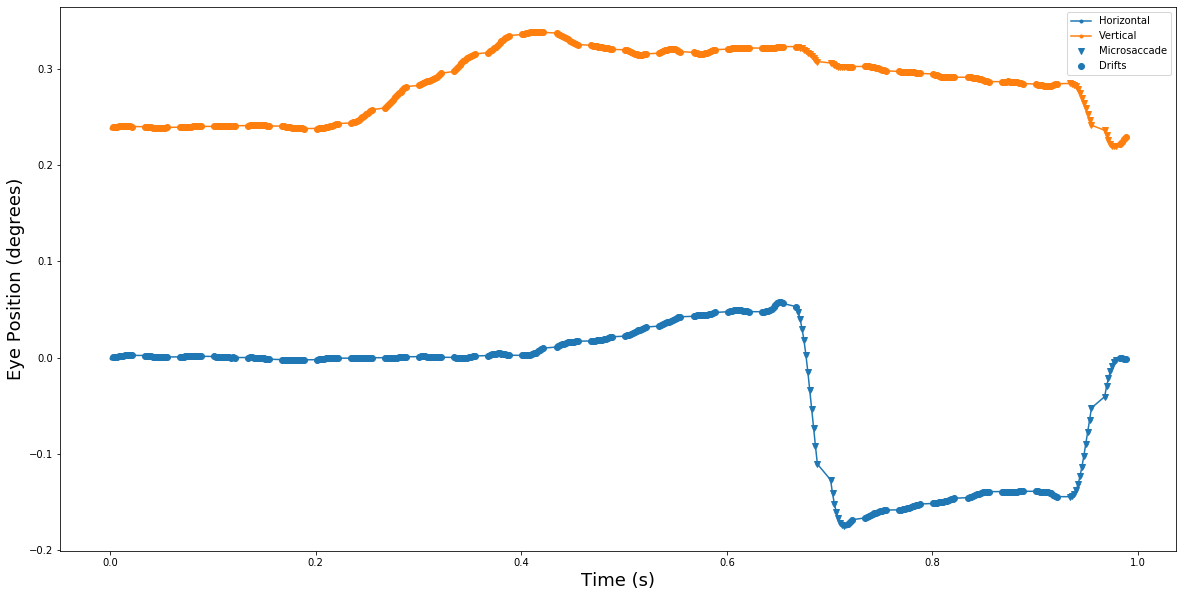

In [11]:
code='12_17_2018_18_47_12_AO001R_010'

data=filteredeyepos.query("code==@code")
# markerDataFiltered=stimTimes.query("code==@code")
SaccFiltered=saccData.query("code==@code")
driftFiltered=driftData.query("code==@code")
plt.figure(figsize=(20,10))
plt.plot(data['time'],data['xpos'],'.-',label='Horizontal')
plt.plot(data['time'],data['ypos'],'.-',color='C1',label='Vertical')
# try:
#     ax=plt.axvline(x=markerDataFiltered['stimlusOnsetTime'][0],ymin=0,ymax=1,ls='--')
# except:
#     ax=plt.axvline(x=markerDataFiltered['stimlusOnsetTime'][1],ymin=0,ymax=1,ls='--')
if len(SaccFiltered)>0:
    for i in range(len(SaccFiltered)):
        x=data['time'].iloc[int(SaccFiltered['onsetIdx'].iloc[i]):int(SaccFiltered['offsetIdx'].iloc[i])]
        y1=data['xpos'].iloc[int(SaccFiltered['onsetIdx'].iloc[i]):int(SaccFiltered['offsetIdx'].iloc[i])]
        y2=data['ypos'].iloc[int(SaccFiltered['onsetIdx'].iloc[i]):int(SaccFiltered['offsetIdx'].iloc[i])]
        plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
        plt.plot(x,y2,'v',color='C1')
        
if len(driftFiltered)>0:
    for k in range(len(driftFiltered)):
        x=data['time'].iloc[int(driftFiltered['onsetIdx'].iloc[k]):int(driftFiltered['offsetIdx'].iloc[k])]
        y1=data['xpos'].iloc[int(driftFiltered['onsetIdx'].iloc[k]):int(driftFiltered['offsetIdx'].iloc[k])]
        y2=data['ypos'].iloc[int(driftFiltered['onsetIdx'].iloc[k]):int(driftFiltered['offsetIdx'].iloc[k])]
        plt.plot(x,y1,'o',color='C0',label='Drifts' if k==0 else "")
        plt.plot(x,y2,'o',color='C1')
plt.legend()
plt.xlabel('Time (s)', size=18)
plt.ylabel('Eye Position (degrees)', size=18)
            
# plt.savefig('SampleEyeTraceWithSaccade.pdf',bbox_tight=True)

Text(0, 0.5, 'Y Position (arcmin)')

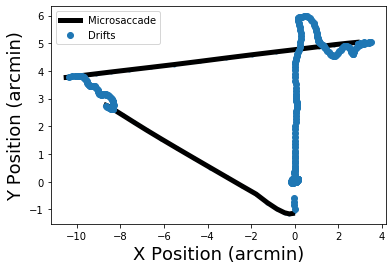

In [59]:
code='12_17_2018_18_47_12_AO001R_010'

data=filteredeyepos.query("code==@code")
# markerDataFiltered=stimTimes.query("code==@code")
SaccFiltered=saccData.query("code==@code")
driftFiltered=driftData.query("code==@code")
# plt.figure(figsize=(20,10))
xdata=data['xpos']-data['xpos'].iloc[0]
ydata=data['ypos']-data['ypos'].iloc[0]
ax=plt.plot(xdata*60,ydata*60,'.-')
# try:
#     ax=plt.axvline(x=markerDataFiltered['stimlusOnsetTime'][0],ymin=0,ymax=1,ls='--')
# except:
#     ax=plt.axvline(x=markerDataFiltered['stimlusOnsetTime'][1],ymin=0,ymax=1,ls='--')
if len(SaccFiltered)>0:
    for i in range(len(SaccFiltered)):
        x=xdata.iloc[int(SaccFiltered['onsetIdx'].iloc[i]):int(SaccFiltered['offsetIdx'].iloc[i])]*60
        y=ydata.iloc[int(SaccFiltered['onsetIdx'].iloc[i]):int(SaccFiltered['offsetIdx'].iloc[i])]*60
        plt.plot(x,y,ls='-',color=[0,0,0],linewidth=5,label='Microsaccade' if i==0 else "")
        
if len(driftFiltered)>0:
    for k in range(len(driftFiltered)):
        x=xdata.iloc[int(driftFiltered['onsetIdx'].iloc[k]):int(driftFiltered['offsetIdx'].iloc[k])]*60
        y=ydata.iloc[int(driftFiltered['onsetIdx'].iloc[k]):int(driftFiltered['offsetIdx'].iloc[k])]*60
        plt.plot(x,y,'o',color='C0',label='Drifts' if k==0 else "")
plt.legend()
plt.xlabel('X Position (arcmin)', size=18)
plt.ylabel('Y Position (arcmin)', size=18)

# plt.savefig('SampleEyeTrace2DwithEvents.pdf',bbox_tight=True)

Text(0, 0.5, 'Y Position (arcmin)')

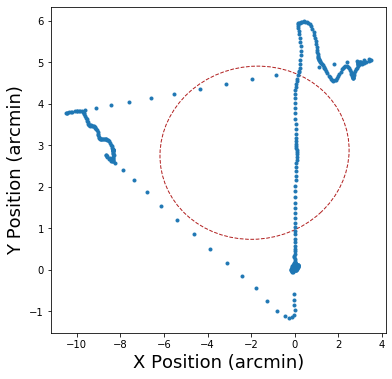

In [60]:
code='12_17_2018_18_47_12_AO001R_010'

data=filteredeyepos.query("code==@code")
# markerDataFiltered=stimTimes.query("code==@code")
SaccFiltered=saccData.query("code==@code")
driftFiltered=driftData.query("code==@code")
# plt.figure(figsize=(20,10))
data=data[data['xpos'].notnull()]
x=(data['xpos']-data['xpos'].iloc[0])*60
y=(data['ypos']-data['ypos'].iloc[0])*60
fig, ax_nstd = plt.subplots(figsize=(6, 6))
ax_nstd.plot(x,y,'.')

confidence_ellipse(x, y, ax_nstd, n_std=1,
                    edgecolor='firebrick',linestyle='--')
plt.xlabel('X Position (arcmin)', size=18)
plt.ylabel('Y Position (arcmin)', size=18)


In [ ]:
print(len(np.diff(data['xpos'])),len(np.diff(data['time'])))

Text(0, 0.5, 'Vy (°/s)')

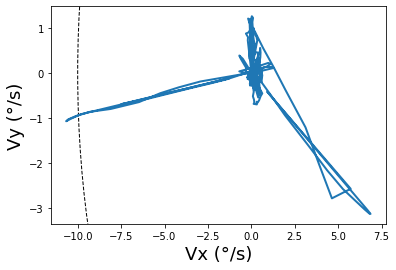

In [39]:
code='12_17_2018_18_47_12_AO001R_010'

data=filteredeyepos.query("code==@code")
# markerDataFiltered=stimTimes.query("code==@code")
# plt.figure(figsize=(20,10))
data=data[data['xpos'].notnull()]
xdiff=(np.diff(data['xpos']))/(np.diff(data['time']))
ydiff=np.diff(data['ypos'])/np.diff(data['time'])
plt.plot(xdiff,ydiff,'-',linewidth=2)
fig = plt.gcf()
ax = fig.gca()
a_circle = plt.Circle((0, 0), 10,fill=False,ls='--')
ax.add_artist(a_circle)
# plt.xlim(-15,15)
# plt.ylim(-15,15)
plt.xlabel('Vx (°/s)', size=18)
plt.ylabel('Vy (°/s)', size=18)

# plt.savefig('SampleEyeTrace2DVelocityProfileZoomed.pdf')

Populating the interactive namespace from numpy and matplotlib


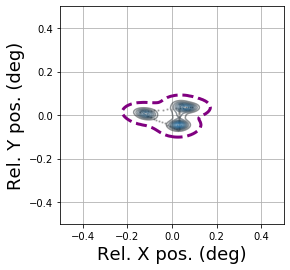

In [14]:
%pylab inline
import pandas as pd
import seaborn as sns
import statsmodels.nonparametric.api as smnp
centering="mean" # mean, None
# x=np.random.normal(scale=0.6,size=1000)
# y=np.random.normal(scale=0.6,size=1000)
x=data['xpos']
y=data['ypos']
if True:
        df_poss=pd.DataFrame( {'x':x,'y':y} )
                             
        if centering=='first':
            df_poss.x = (df_poss.x-(df_poss.x[0]))
            df_poss.y = (df_poss.y-(df_poss.y[0]))
        elif centering=='mean':
            df_poss.x = (df_poss.x-np.mean(df_poss.x))
            df_poss.y = (df_poss.y-np.mean(df_poss.y))                             
        plt.figure(figsize=(4,4))
        sns.kdeplot(df_poss.x,df_poss.y,ax=plt.gca(), alpha=0.5)#, data=df_poss)
        sns.scatterplot(x='x',y='y',data=df_poss, s=5, color='k', alpha=0.4)
        plt.grid()
        plt.xlabel("Rel. X pos. (deg)", size=18)
        plt.ylabel("Rel. Y pos. (deg)", size=18)
        xl=plt.xlim(-0.5,0.5)
        yl=plt.ylim(-0.5,0.5)
        kde=smnp.KDEMultivariate( [df_poss.x, df_poss.y], "cc" )
        x_support=np.linspace(xl[0],xl[1],200)
        y_support=np.linspace(yl[0],yl[1],200)
        xx, yy = np.meshgrid(x_support, y_support)
        z = kde.pdf([xx.ravel(), yy.ravel()]).reshape(xx.shape)
        ax=plt.gca()
        cset=plt.contour(xx,yy,z, levels=[1-0.682], linestyles='dashed', linewidths=3, colors='purple')

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
C:\Users\krish\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\krish\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Probability')

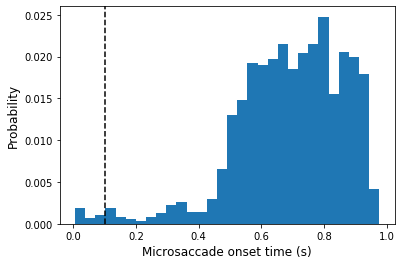

In [8]:
# plt.figure(figsize=(20,10))
# saccData['VectorAmp'].min()

# sns.distplot((saccData['VectorAmp']),kde=True)
weights = np.ones_like(saccData['onsetTime'])/float(len(saccData['onsetTime']))
plt.hist(saccData['onsetTime'],weights=weights,bins=30,normed=0)
plt.axvline(x=0.100,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.xlabel('Microsaccade onset time (s)',size=12)
plt.ylabel('Probability',size=12)
# plt.savefig('SaccadeOnsetTimeHistogram.pdf',bbox_tight=True)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


Text(0, 0.5, 'Probability')

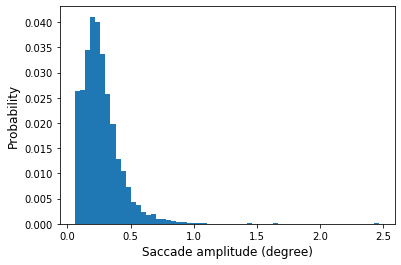

In [10]:
# plt.figure(figsize=(20,10))
# saccData['VectorAmp'].min()

# sns.distplot((saccData['VectorAmp']),kde=True)
weights = np.ones_like(saccData['VectorAmp'])/float(len(saccData['VectorAmp']))
plt.hist(saccData['VectorAmp'],weights=weights,bins=60,normed=0)
plt.xlabel('Saccade amplitude (degree)',size=12)
plt.ylabel('Probability',size=12)
# plt.savefig('SaccadeAmplitudeHistogram.pdf',bbox_tight=True)

In [ ]:
plt.figure(figsize=(20,10))
# saccData['VectorAmp'].min()
sns.lineplot(x='onsetTime',y='VectorAmp',data=saccDataMerged)
# plt.xlabel('Saccade amplitude (arc min)')
# plt.savefig('SaccadeAmplitudeHistogram.pdf')

In [ ]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt

# two input arrays
data=saccDataMerged.query("VectorAmp<0.5")
azimut=np.radians(data['DirectionPolar'])
radius=data['VectorAmp']*60

# define binning
rbins = np.linspace(0,radius.max(), 15)
abins = np.linspace(0,2*np.pi, 60)

#calculate histogram
hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
A, R = np.meshgrid(abins, rbins)

# plot
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")
# ax.set_theta_zero_location("W")  # theta=0 on the left
# ax.set_theta_direction(1) 
fig.colorbar(pc)
# plt.title('eccentricity: All',y=1.08)
plt.savefig('MicrosaccadeDirectionAllArcMin.pdf',bbox_tight= True)

In [ ]:
def rose_plot(ax, angles, bins=16, density=None, offset=0, lab_unit="degrees",
              start_zero=False, **param_dict):
    """
    Plot polar histogram of angles on ax. ax must have been created using
    subplot_kw=dict(projection='polar'). Angles are expected in radians.
    """
    # Wrap angles to [-pi, pi)
    angles = (angles + np.pi) % (2*np.pi) - np.pi

    # Set bins symetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)

    # By default plot density (frequency potentially misleading)
    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radius = (area / np.pi)**.5
    else:
        radius = count

    # Plot data on ax
    ax.bar(bin[:-1], radius, zorder=1, align='edge', width=widths,
           edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels, they are mostly obstructive and not informative
    ax.set_yticks([])
#     ax.set_ylim(0,0.40)
    ax.tick_params(axis='both',which='major',labelsize=10)

    if lab_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)

In [ ]:
angles0 = np.radians(saccDataMerged.query("VectorAmp<0.5")['DirectionPolar'])
fig, ax = plt.subplots(1,2 , subplot_kw=dict(projection='polar'),figsize=(20,10))
rose_plot(ax[0], angles0,bins=20)
ax[0].title.set_text('Microsaccade Direction')


In [ ]:
angles0 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==0.")['DirectionPolar'])
angles1 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==0.5")['DirectionPolar'])
angles2 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==1")['DirectionPolar'])
angles3 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==1.5")['DirectionPolar'])
angles4 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==2")['DirectionPolar'])
angles5 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==3")['DirectionPolar'])
angles6 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==4")['DirectionPolar'])
angles7 = np.radians(saccDataMerged.query("VectorAmp<0.5 & ecc==5")['DirectionPolar'])
# Visualise with polar histogram
fig, ax = plt.subplots(2,4 , subplot_kw=dict(projection='polar'),figsize=(20,10))
rose_plot(ax[0,0], angles0,bins=20)
rose_plot(ax[0,1], angles1,bins=20)
rose_plot(ax[0,2], angles2,bins=20)
rose_plot(ax[0,3], angles3,bins=20)
rose_plot(ax[1,0], angles4,bins=20)
rose_plot(ax[1,1], angles5,bins=20)
rose_plot(ax[1,2], angles6,bins=20)
rose_plot(ax[1,3], angles7,bins=20)
ax[0,0].title.set_text('Ecc:0°')
ax[0,0].title.set_position([0.5,1,2,2])
ax[0,1].title.set_text('Ecc:0.5°')
ax[0,1].title.set_position([0.5,1,2,2])
ax[0,2].title.set_text('Ecc:1°')
ax[0,2].title.set_position([0.5,1,2,2])
ax[0,3].title.set_text('Ecc:1.5°')
ax[0,3].title.set_position([0.5,1,2,2])
ax[1,0].title.set_text('Ecc:2')
ax[1,0].title.set_position([0.5,1,2,2])
ax[1,1].title.set_text('Ecc:3°')
ax[1,1].title.set_position([0.5,1,2,2])
ax[1,2].title.set_text('Ecc:4°')
ax[1,2].title.set_position([0.5,1,2,2])
ax[1,3].title.set_text('Ecc:5°')
ax[1,3].title.set_position([0.5,1,2,2])
ttl=fig.gca().set_title('Direction of microsaccades',fontsize=20)
ttl.set_position([-1.5,2.6])
fig.show()
fig.subplots_adjust(hspace=.2,wspace=0.4)

# fig.tight_layout()
# fig.savefig('DirectionHistogramAll.pdf',bbox_tight=True)

In [ ]:
sns.pointplot(x='barwidths',y=)

In [ ]:
#TODO sns plot by subject
# plt.figure(figsize=(20,10))
# mydata=saccDataMerged.query("VectorAmp<0.5")
sns.lmplot(x="VectorAmp",y="peakVel",data=saccDataMerged,fit_reg=False,markers='.')
# plt.xlim(0,80)
# plt.ylim(0,80)
plt.axvline(x=0.5,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.xlabel('Saccade Amplitude (deg)')
plt.ylabel('Peak Velocity (°/s)')
plt.yscale('log')
plt.xscale('log')
# plt.savefig('MainSequencePlotLogScale.pdf',bbox_tight=True)


In [ ]:
# here we segregate the microsaccade data based on whether they were leftward or rightward.
# Criterion is based on Baumeler et al. 2020
rightupSacc=saccDataUnfiltered.query("DirectionPolar<85 ")
rightdownSacc=saccDataUnfiltered.query("(DirectionPolar>275)")
rightwardSacc=rightupSacc.append(rightdownSacc)
rightwardSacc['leftVright']='right'
leftwardSacc=saccDataUnfiltered.query("(DirectionPolar>95) & (DirectionPolar<275)")
leftwardSacc['leftVright']='left'
leftVrightData=leftwardSacc.append(rightwardSacc)              

In [ ]:
leftdata=leftwardSacc.query("VectorAmp<0.5 & onsetTime<0.7")
rightdata=rightwardSacc.query("VectorAmp<0.5 & onsetTime<0.7")
sns.distplot(leftdata['onsetTime'],label='Leftward Saccade')#,bins=40)
sns.distplot(rightdata['onsetTime'],label='Rightward Saccade')#,bins=40)
ax=plt.axvline(0.100,ymin=0,ymax=1,ls='--')
plt.legend()
# plt.savefig('saccadeOnsetTimeHueDirectionTrimmedTime.pdf',bbox_tight=True)

In [ ]:
varList=saccDataUnfiltered['barwidths'].unique()
# filterSacc=saccDataUnfiltered.query("VectorAmp<0.5")
microSaccEarly=pd.DataFrame({'var':[],'NumSacc':[],'Numtrials':[]})
microSaccLate=pd.DataFrame({'var':[],'NumSacc':[],'Numtrials':[]})
for avar in varList:
    for i in range(2):
        if i==0:
            data=filterSacc.query("barwidths==@avar & ntrial<14")
            behavtemp=behavData.query("barwidths==@avar & ntrial<14")
            num=len(data['code'].unique())
            numtrial=len(behavtemp)
            microSaccEarly=microSaccEarly.append({'var':avar,'NumSacc':num,'Numtrials':numtrial},ignore_index=True)
        else:
            data=filterSacc.query("barwidths==@avar & ntrial>14")
            behavtemp=behavData.query("barwidths==@avar & ntrial>14")
            num=len(data['code'].unique())
            numtrial=len(behavtemp)
            microSaccLate=microSaccLate.append({'var':avar,'NumSacc':num,'Numtrials':numtrial},ignore_index=True)

microSaccEarly['condition']='Early'
microSaccLate['condition']='Late'
microSaccEarly['prob']=microSaccEarly['NumSacc']/microSaccEarly['Numtrials']    
microSaccLate['prob']=microSaccLate['NumSacc']/microSaccLate['Numtrials']  
microSacc=microSaccEarly.append(microSaccLate)
microSacc.sort_values('var')
# microSaccRate=pd.merge(microSaccRate,behavData,left_on='code',right_on='code')

sns.barplot(data=microSacc,x='var',y='prob',hue='condition',ci='sd')
plt.xlabel('Nominal Spacing')
plt.ylim(0,0.5)
# plt.savefig('saccProbvsSpacing.pdf',bbox_tight= True)

In [ ]:
microSaccE=[]
microSaccL=[]
for i in range(2):
    if i==0:
        data=saccDataUnfiltered.query("ntrial<14")
        microSaccE.append(data)
    else:
        data=saccDataUnfiltered.query("ntrial>14")
        microSaccL.append(data)
microSaccE=pd.concat(microSaccE)
microSaccL=pd.concat(microSaccL)
microSaccE['condition']='Early'
microSaccL['condition']='Late'
microSaccEvL=microSaccE.append(microSaccL)
# microSaccRate=pd.merge(microSaccRate,behavData,left_on='code',right_on='code')

In [ ]:
counts=saccDataMerged.groupby(['barwidths','code']).count()
mean=counts.groupby('barwidths')['Unnamed: 0_x'].mean()
std=counts.groupby('barwidths')['Unnamed: 0_x'].std()

In [ ]:
mean.plot(kind='bar',yerr=std,capsize=5)
plt.ylabel('Num Microsaccades/sec')

In [ ]:
bceaDFE=[]
bceaDFL=[]
for i in range(2):
    if i==0:
        data=bceaDF.query("ntrial<14")
        bceaDFE.append(data)
    else:
        data=bceaDF.query("ntrial>14")
        bceaDFL.append(data)
bceaDFE=pd.concat(bceaDFE)
bceaDFL=pd.concat(bceaDFL)
bceaDFE['EvL']='Early'
bceaDFL['EvL']='Late'
bceaDF=bceaDFE.append(bceaDFL)
# microSaccRate=pd.merge(microSaccRate,behavData,left_on='code',right_on='code')

In [ ]:
bceaDF['bceaArcMin']=bceaDF['bcea']*60*60
sns.pointplot(x='ecc',y='bceaArcMin',hue='subj',data=bceaDF)
plt.xlabel('Eccentricity (deg)',size=12)
plt.ylabel('BCEA (arc min^2)',size=12)
plt.yscale('log')
print( plt.gca().get_ylim())
# plt.savefig('bceaVecc.pdf',bbox_tight=True)

In [ ]:
df1=bceaDF.replace(to_replace=9.9,value=np.inf,regex=True)
df1=df1.query("barwidths!=6")
sns.pointplot(x='barwidths',y='bceaArcMin',data=df1)
plt.ylim((35.914700637205755, 67.65826373927582))
plt.xlabel('Flanker spacing (deg)',size=12)
plt.ylabel('BCEA (arc min^2)',size=12)
# plt.savefig('bceaVflankerspacing.pdf',bbox_tight=True)

In [ ]:
# 1. create two subplots
f,(ax,ax2) = plt.subplots(1,2,sharey=True, facecolor='w')#,gridspec_kw={'width_ratios': [10, 2]})
# 2. plot the same data on both axes
sns.pointplot(x='barwidths',y='bceaArcMin',data=df1,ax=ax)
sns.pointplot(x='barwidths',y='bceaArcMin',data=df1,ax=ax2)
# ax.bar(x, y)
# ax2.bar(x, y)
# f.set_figheight(6)
# f.set_figwidth(12)


# 3. limit each x axis to the chosen range
a=-0.5
b=4.5
c=4.5
d=10
ax.set_xlim(a,b)
ax2.set_xlim(c,d)


# 4. hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_visible(False)
ax.yaxis.tick_left()
ax2.tick_params(labelleft='off')


# 5. This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
f.subplots_adjust(wspace=.05)

# 6. Make some labels.
rects = ax.patches
# labels = ["%d" % i for i in y]
# for i, rect, label in zip(x,rects, labels):
#     height = rect.get_height()
#     print(i)
#     if i < b:
#         ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
#             ha='center', va='bottom')
#     elif i > c:
#         ax2.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
#             ha='center', va='bottom')

ax.set_xlabel('Flanker spacing (deg)',size=12)
ax.set_ylabel('BCEA (arc min^2)',size=12)
ax2.set_xlabel('')
# plt.ylabel('BCEA (arc min^2)',size=12)
# plt.show()

# plt.savefig('bceaVflankerspacingXTick.pdf',bbox_tight=True)

In [ ]:
rightup=saccDataMerged.query("DirectionPolar<45")
rightdown=saccDataMerged.query("DirectionPolar>315")
rightSacc=rightup.append(rightdown)
upSacc=saccDataMerged.query("45<DirectionPolar<135")
leftSacc=saccDataMerged.query("135<DirectionPolar<225")
downSacc=saccDataMerged.query("225<DirectionPolar<315")
rightSacc['NEWS']='right'
upSacc['NEWS']='up'
leftSacc['NEWS']='left'
downSacc['NEWS']='down'
newsDF=[rightSacc,leftSacc,downSacc,upSacc]
newsDF=pd.concat(newsDF)


In [ ]:
dirs=[0,90,180,270]
subs=["AO001R","AO020R"]
dirEarly=saccDataMerged.query('onsetTime<0.7')
num_list=[]
conditions=['ecc>=0']
# conditions=['barwidths==1','barwidths==2','barwidths==3','barwidths==4','barwidths==5','barwidths==9.9']
# conditions=['ecc==0 & barwidths<=3',
#             'ecc==0 & barwidths>3',
#             '0<ecc<=2 & barwidths<=3',
#             '0<ecc<=2 & barwidths>3',
#             '2<ecc & barwidths<=3',
#             '2<ecc & barwidths>3'
#            ]
vals2=np.zeros( (len(conditions),len(dirs),4))
for ncond,cond in enumerate(conditions):
    quer=cond # Base query is the condition string
    for ntarg,targ in enumerate(dirs):
        quer += '& stim==@targ' # Add direction query
        df1=dirEarly.query(quer)
        ntrials1=len( behavData.query(quer) ) # num trials in that cond.+direction
        num_list.append(ntrials1)
        vals2[ncond,ntarg,0]=df1.query(' 45>DirectionPolar | DirectionPolar>(360-45)' ).count()['DirectionPolar']
        vals2[ncond,ntarg,1]=df1.query('( 90-45)<DirectionPolar<( 90+45)' ).count()['DirectionPolar']
        vals2[ncond,ntarg,2]=df1.query('(180-45)<DirectionPolar<(180+45)' ).count()['DirectionPolar']
        vals2[ncond,ntarg,3]=df1.query('(270-45)<DirectionPolar<(270+45)' ).count()['DirectionPolar']
        vals2[ncond,ntarg] /= ntrials1
        print (ntrials1,end=' ')
    print()
plt.figure(figsize=(15,5))
for ncond in np.arange(len(conditions)):
    plt.subplot(1,len(conditions),ncond+1,label=ncond)
    for nstim in np.arange(len(dirs)):
        plt.plot( vals2[ncond,nstim], label=dirs[nstim] )
    plt.title(conditions[ncond],size=8)
    plt.ylim(0.0,0.1)
    plt.xticks(range(4), dirs);
    plt.grid()
    if ncond==0:
#         plt.xlabel('Microsaccade direction', size=18)
        plt.ylabel('Prop. of trials', size=18)
    else:
        plt.gca().set_yticklabels([])
        
    
plt.legend()

In [ ]:
ax=sns.pointplot(x='EvL',y='bcea',data=bceaDF)
plt.ylabel('BCEA (deg^2)')
# ax.set_yscale('log')
# plt.savefig('BCEAvEcc.pdf')
#TODO: unflanked 

In [ ]:
fovealData=saccDataMerged.query("ecc==0.0 & barwidths>3")
angles0 = np.radians(fovealData.query("stim==0")['DirectionPolar'])
angles1=np.radians(fovealData.query("stim==90")['DirectionPolar'])
angles2=np.radians(fovealData.query("stim==180")['DirectionPolar'])
angles3=np.radians(fovealData.query("stim==270")['DirectionPolar'])
fig, ax = plt.subplots(2,2,subplot_kw=dict(projection='polar'),figsize=(20,10))
rose_plot(ax[0,0], angles0)
rose_plot(ax[0,1], angles1)
rose_plot(ax[1,0], angles2)
rose_plot(ax[1,1], angles3)
ax[0,0].title.set_text('Orientation:0')
ax[0,1].title.set_text('Orientation:90')
ax[1,0].title.set_text('Orientation:180')
ax[1,1].title.set_text('Orientation:270')
ax[0,0].title.set_position([0.50,1])
ax[0,1].title.set_position([0.50,1])
ax[1,0].title.set_position([0.50,1])
ax[1,1].title.set_position([0.50,1])
ttl=fig.gca().set_title('Direction of microsaccades: Stimulus Orientation',fontsize=20)
ttl.set_position([-0.90,2.50])
fig.show()
fig.subplots_adjust(hspace=.3,wspace=0.3)
# plt.savefig('DirectionofMicrosaccades_Foveal_stimOrientation.pdf',bbox_true=True)

In [ ]:
codeList=filteredeyepos['code'].unique()
mydata=filteredeyepos[filteredeyepos['xpos'].notnull()]
stdDF=pd.DataFrame({'xSTD':[],'ySTD':[],'code':[]})
counter=1
num_of_elements=len(codeList)
for acode in codeList:
    update_progress(counter / num_of_elements)
    counter+=1
    data=mydata.query("code==@acode")
    xdata=data['xpos'].std()
    ydata=data['ypos'].std()
    stdDF=stdDF.append({'xSTD':xdata,'ySTD':ydata,'code':acode},ignore_index=True)
    
stdDF=pd.merge(stdDF,behavData,left_on='code',right_on='code')

In [ ]:
g = sns.lmplot('xSTD','ystd',hue='barwidths',data=stdDF,fit_reg=False)
# plt.savefig('XandYShifts.pdf',bbox_tight=True)

In [ ]:
filteredeyepos['ypos'].max()

In [ ]:
## Matplotlib plots
data=saccDataUnfiltered.query("VectorAmp<0.5")
# data['VectorAmp']=data['VectorAmp']*60
variable='VectorAmp'
groupby='DirectionPolar'
microSaccData=data.groupby([groupby]).mean()[variable]
error_bar=data.groupby([groupby])[variable].std()

microSaccData.plot(kind='bar',yerr=error_bar,capsize=5,color=(0.2, 0.4, 0.6, 0.6))
# plt.ylabel('MicroSaccAmplitude',size=11)
# plt.xlabel('Trial No',size=12)
# plt.title('Microsaccadic rate')

In [ ]:
data=leftVrightData.query("VectorAmp<0.5")
data.groupby(['correct','leftVright'])['Unnamed: 0_x'].count().plot(kind='bar')


In [ ]:
data=leftVrightData.query("correct==1")
sns.point
# sns.pointplot(x='leftVright',y='onsetTime',hue='correct',data=data)
# plt.savefig('saccadeOnsetTimeHueCorrectFoveaexcluded.pdf',bbox_tight=True)

In [ ]:
data0=saccDataMerged.groupby(['ecc'])['code'].nunique().reset_index()
data1=saccDataMerged.groupby(['ecc'])['code'].count().reset_index()
data=pd.merge(data0,data1,left_on='ecc',right_on='ecc')
data['mSaccRate']=data['code_x']/data['code_y']